In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

import sys
sys.path.append("C:/Users/Leon/Documents/AI_project/AI_project")
from Image_processing.Preprocessing.utils import preprocessing as prep

***Show the Image***

In [63]:
import importlib
importlib.reload(prep)

<module 'Image_processing.Preprocessing.utils.preprocessing' from 'C:\\Users/Leon/Documents/AI_project/AI_project\\Image_processing\\Preprocessing\\utils\\preprocessing.py'>

***height (rows), width(cols)***

Load images from storage and pass them through the preprocessing pipeline. The individual steps are:<br>
- Read Image as BGR Format<br>
- Resize Image to square format<br>
- Draw bounding box around the object in the image and convert it to RGB<br>
- get Hight and Width from the bounding box<br>
- check If the box is rotated and depending on that crop the area of the bounding box out of the image<br>
- Do Object Segmentation on the cropped image and return the binary segmented img (mask)<br>
- Get the segmented cropped RGB image<br>
- Place a green mask on the segmented cropped RGB image and get only the green pixels<br>
- Calculate the color from the segmented cropped RGB image with kmeans algorithm. Set k=2<br>
- Write the desired features to the dataframe

In [ ]:
folders = ["Kartoffel", "Karotte", "Zwiebel", "Karotte_Trieb", "Zwiebel_Trieb", "Kartoffel_Trieb"]
#folders = ["Internet"]
paths = []
for fold in folders:
    for fname in os.listdir(f"G:/Meine Ablage/KI_Projekt/Testdaten/{fold}"):
        paths.append(f"G:/Meine Ablage/KI_Projekt/Testdaten/{fold}/{fname}")
paths[0]  

In [57]:
demo_img = ['G:/Meine Ablage/KI_Projekt/Trainingsdaten/Karotte_Trieb/karotte_trieb_100.jpg'] # 209 previous
paths = demo_img

In [58]:
vegis_df = pd.DataFrame(columns=["Hight", "Width", "R", "G", "B", "green pixels",
                                 "green onion pixels", "ratio area", "circularity", 
                                 "keypoints", "mean keypoints", "Label", "Image"])
error_counter = 0
for i, path in enumerate(paths):
    if 'desktop.ini' in path:
        continue

    ############################# Label the image ##################################
    vegi_label = path.split("/")[4]
 
    vegi_BGR = cv2.imread(path) # As BGR
    vegi_sq_BGR_original = prep.resize_to_square(vegi_BGR) # BGR

    try:
        ############################# Find Contours in image and draw a bounding box ##################################
        vegi_with_box_rgb, more_than_one_box, box, rect, area, circularity = prep.draw_contours(vegi_sq_BGR_original, object_area=500)
        if more_than_one_box:
            box_size = 500
            while more_than_one_box:  # makes sure there is only one bounding box in the image
                box_size += 250
                vegi_with_box_rgb, more_than_one_box, box, rect, area, circularity = prep.draw_contours(vegi_sq_BGR_original, box_size)

        ############################# Get pixel size from the bounding box (hight and width) ##################################
        h, w = [int(l) for l in prep.get_size_box(box)]
        
        ############################# Calculate the Ratio Area Feature ##################################
        ratio_area_box = 0
        if h > 0 and w > 0:
            ratio_area_box = area / (h * w)

        ############################# Crop the including area from the bounding box (our ROI) ##################################
        if not prep.is_box_rotated(box):
            #crop img directly
            # the top left corner should be the first element in box array
            cropped_vegi_BGR = vegi_sq_BGR_original[box[0][1]:box[0][1]+h, box[0][0]:box[0][0]+w]
            
        else:
            cropped_vegi_BGR = prep.crop_roi(vegi_sq_BGR_original, box) # BGR

        ############################# Do a binary segmentation only with the roi  ##################################
        cropped_segmented_binary_2 = prep.segment_img_2(cropped_vegi_BGR)
        #print("Segmented BINARY From Cop NEW")
        #show_image_plt(cropped_segmented_binary_2)

        ############################# Apply the binary mask on the cropped image  ##################################
        cropped_vegi_segmented_rgb_2 = prep.color_from_segmented_binary(cropped_segmented_binary_2, cropped_vegi_BGR) # center has rgb format
        #print("Segmented RGB")
        #show_image_plt(cropped_vegi_segmented_rgb_2)

        ##################### SIFT Algorithm - Calculates the mean keypoints and number of keypoints features #######################################
        num_kps, mean_kps = prep.sift(vegi_sq_BGR_original)

        ############################# Apply a green mask on the image ##################################
        # Seems to be work best
        vegi_only_onion_tribe_rgb, onion_tribe_mask = prep.mask_green(cropped_vegi_segmented_rgb_2, lower_thresh=(25, 40, 20), higher_thresh=(60, 160, 255))
        #print("ONLY GREEn TRIBE MASK")
        #show_image_plt(vegi_only_onion_tribe_rgb)
        vegi_only_tribe_rgb, tribe_mask = prep.mask_green(cropped_vegi_segmented_rgb_2, lower_thresh=(27, 105, 20), higher_thresh=(120, 255, 255))
        ############################# Calculates the number of green pixels feature  ##################################
        amount_green_pixels_onion_tribe = prep.count_green_pixels(onion_tribe_mask)
        amount_green_pixels_tribe = prep.count_green_pixels(tribe_mask)
        ############################# Get the Color (R, G, B) Feature(s) with a kmean algorithm ##################################
        center, ret, label = prep.get_color(cropped_vegi_segmented_rgb_2) #Center = RGB
        R, G, B = np.max(center, axis=0)
        
        a = path.split(".")
        b = a[0].split("_")
        img_name = f"{vegi_label}_{b[-1]}"
        vegis_df.loc[len(vegis_df)] = [h, w, R, G, B, amount_green_pixels_tribe, amount_green_pixels_onion_tribe, ratio_area_box, circularity, num_kps, mean_kps, vegi_label, img_name]
        
        if i < 3:
            print(vegis_df)
        
    except Exception as e:
        print(f"########## Error: {e}")
        error_counter += 1
    

   Hight  Width    R   G   B  green pixels  green onion pixels  ratio area  \
0    259    110  108  88  50          2762                1477    0.000614   

   circularity  keypoints  mean keypoints          Label              Image  
0     0.154427         57        7.554189  Karotte_Trieb  Karotte_Trieb_100  


The resized image to 256x256 pixels


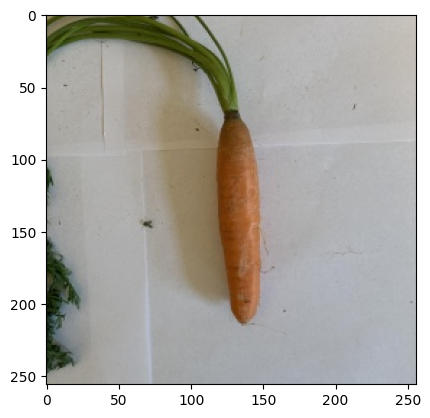

Shows the bounding box which was drawed around the founded contours


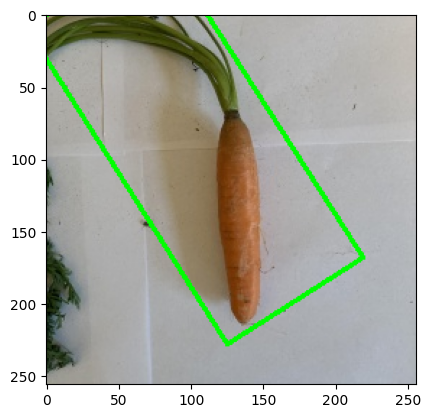

Segmented Binary Image 


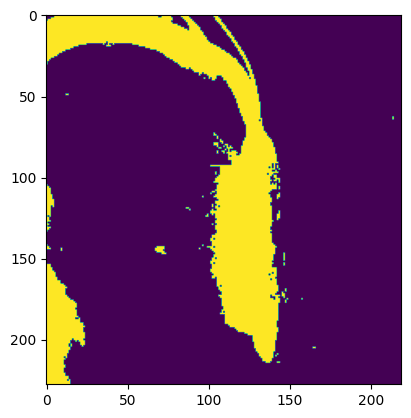

Segmented Image after applying the binary mask


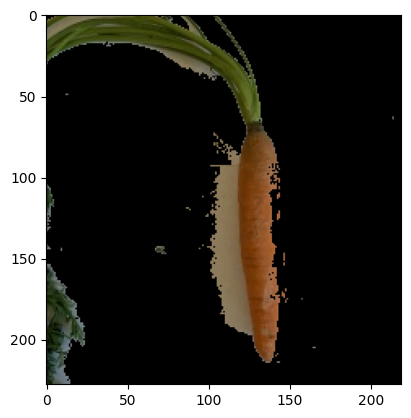

Shows the green color mask to get only the green pixels from the image


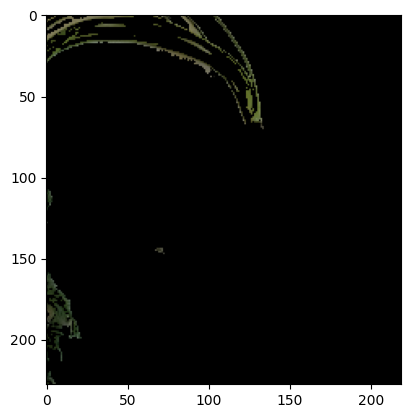

In [59]:
print("The resized image to 256x256 pixels")
prep.show_image_plt(cv2.cvtColor(vegi_sq_BGR_original, cv2.COLOR_BGR2RGB))

print("Shows the bounding box which was drawed around the founded contours")
prep.show_image_plt(vegi_with_box_rgb)

print("Segmented Binary Image ")
prep.show_image_plt(cropped_segmented_binary_2)

print("Segmented Image after applying the binary mask")
prep.show_image_plt(cropped_vegi_segmented_rgb_2)

print("Shows the green color mask to get only the green pixels from the image")
prep.show_image_plt(vegi_only_onion_tribe_rgb)

In [ ]:
#vegis_df.to_csv("G:/Meine Ablage/KI_Projekt/Daten/.csv")

Outside count:  2
This is case 2
point_idx_1:  0 point_idx_2:  1
eps:  0.10071942446043165
vector x:  139
vector y:  219
New Point x= 0 y= 31
New Point x= 110 y= 0
Length l_0= 26.076809620810597 and l_1= 58.83026432033091
[(10, 184), (10, 74), (210, 72), (210, 184)]


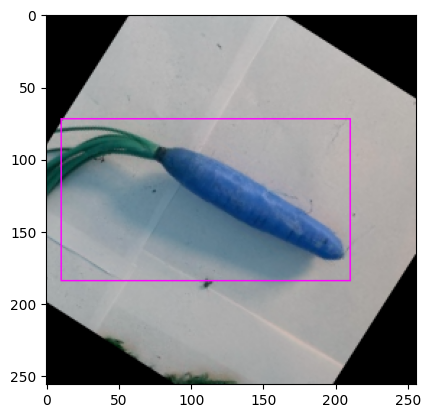

[(10, 184), (10, 72), (210, 72), (210, 184)]


In [64]:
new_img, new_box = prep.resize_bound_box_and_draw(vegi_sq_BGR_original, rect, box)
prep.show_image_plt(new_img)
print(new_box)